# Taller 1


* María Sofía Uribe
* Javier Javier Daza 


Primero importamos las librerías necesarias

In [147]:
import os, zipfile, glob, math, random, joblib


import numpy as np
import pandas as pd

from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from __future__ import annotations

from typing import Iterable, List, Optional, Tuple, Union, Dict
from dataclasses import dataclass, asdict

from skimage.feature import hog
from skimage import io, color, transform, exposure, feature, util

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix



Definimos una función para construir un dataset con los paths de las imágenes desde el directorio fuente y construír las etiquetas a partir de las carpetas en donde se encuentran las imágenes

In [30]:
def load_image_paths_and_labels(DATA_ROOT: str) -> Tuple[List[str], List[str]]:
    """
    Carga las rutas de las imágenes y sus etiquetas a partir de un directorio raíz.

    Este método recorre las subcarpetas dentro del directorio raíz `DATA_ROOT`,
    asumiendo que cada subcarpeta representa una clase distinta (por ejemplo, 
    diferentes tipos de mango). Dentro de cada subcarpeta se buscan archivos de imagen 
    válidos (extensiones comunes como .jpg, .png, .bmp, etc.), y se guardan tanto las 
    rutas como las etiquetas numéricas correspondientes.

    Parámetros
    ----------
    DATA_ROOT : str
        Ruta del directorio raíz que contiene las carpetas de clases con las imágenes.

    Retorna
    -------
    Tuple[List[str], List[int], List[str]]
        - image_paths: lista con las rutas completas de todas las imágenes encontradas.
        - labels: lista de enteros que representan la clase de cada imagen.
        - class_names: lista con los nombres de las clases, según las carpetas.
    """
    root = Path(DATA_ROOT)
    class_dirs = sorted([p for p in root.iterdir() if p.is_dir()])
    class_names, image_paths,labels  = [], [], []
    valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
    for idx, cdir in enumerate(class_dirs):
        class_names.append(cdir.name)
        for p in cdir.rglob("*"):
            if p.is_file() and p.suffix.lower() in valid_exts:
                image_paths.append(str(p))
                labels.append(idx)

    return image_paths, labels,class_names

Definimos una función para mostrar ejemplos de las imágenes de cada clase

In [155]:
def show_examples(df, classes_to_show=range(len(class_names)), per_class=5, seed=RANDOM_STATE):
    random.seed(seed)
    samples = []
    for c in classes_to_show:
        sub = df[df['label'] == c]
        sub = sub[sub['exists'] == True]
        if len(sub) == 0:
            continue
        picks = sub.sample(min(per_class, len(sub)), random_state=seed)
        for _, row in picks.iterrows():
            
            samples.append((c, row['image_path']))
    if not samples:
        print("No hay imágenes disponibles para mostrar.")
        return
    n = len(samples)
    cols = per_class
    rows = math.ceil(n / cols)
    plt.figure(figsize=(5*cols, 3*rows))
    for i, (c, p) in enumerate(samples, 1):
        try:
            img = Image.open(p).convert('RGB')
            plt.subplot(rows, cols, i)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"true = {class_names[c-1]}")
        except Exception as e:
            pass
    plt.tight_layout()
    plt.show()

Cargamos las imágenes, etiquetas y clases 

In [31]:
root = "/kaggle/input/mango-leaf-disease/mango_leaf_disease"
image_paths, labels,class_names = load_image_paths_and_labels(root)

In [164]:
df = pd.DataFrame(image_paths, columns=["image_path"])
df["label"] = labels
df['exists'] = df['image_path'].apply(os.path.exists)
df_counts = df['label'].value_counts().sort_index()

In [168]:
missing_df = (~df['exists']).sum()
print(f"Imágenes faltantes : {missing_df}")

Imágenes faltantes : 0


Observamos que no hay imágenes faltantes en el dataset (todos los directorios son válidos)

Ahora observamos 3 muestras de cada clase

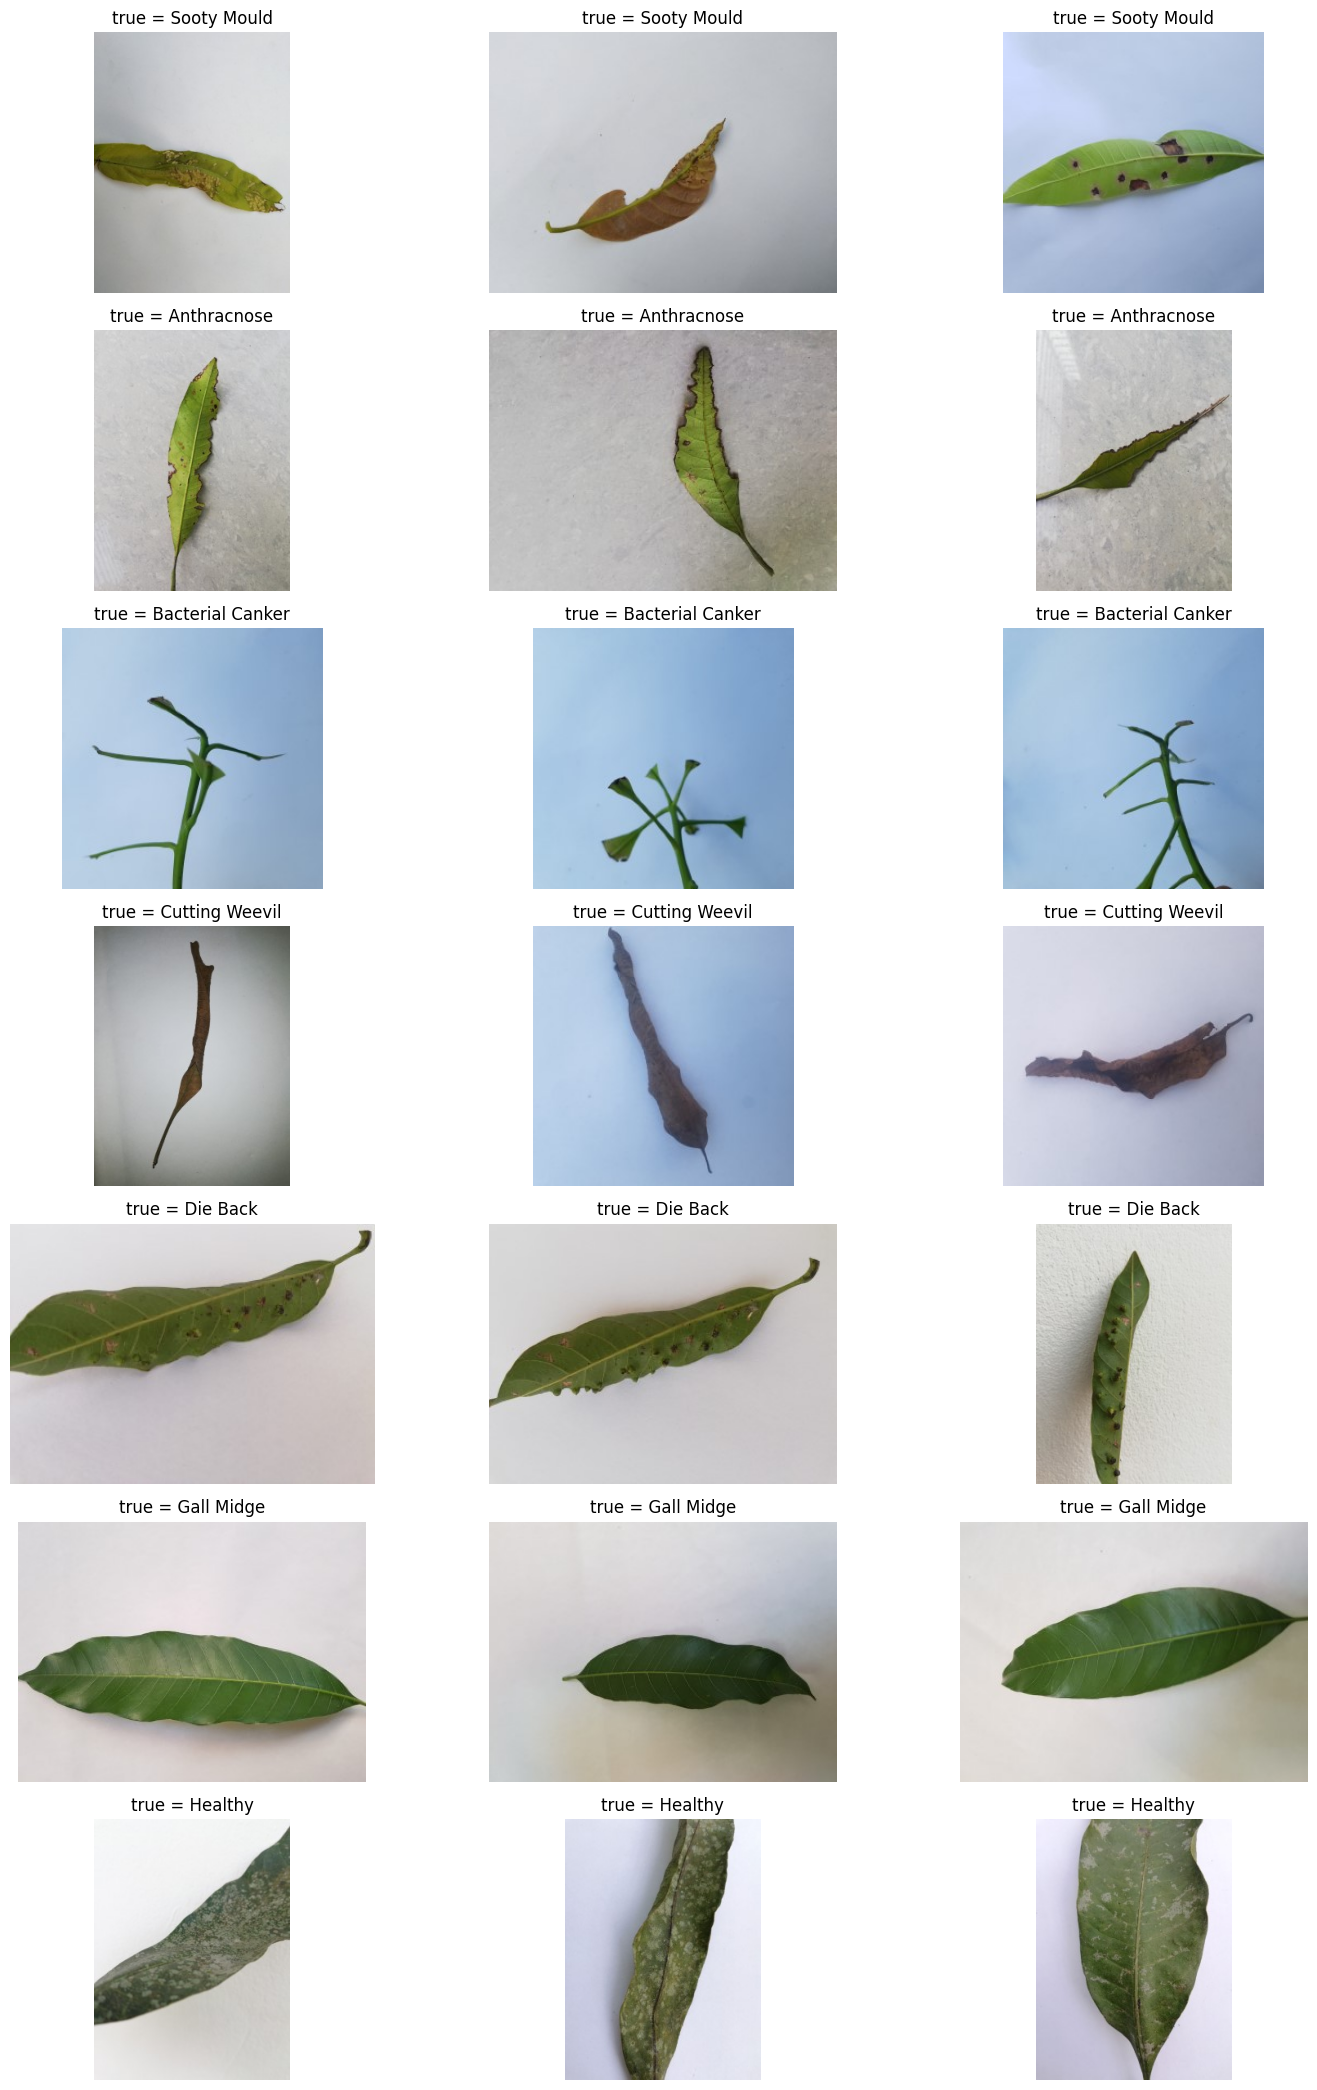

In [165]:
show_examples(df, classes_to_show=range(0, min(7, len(class_names))), per_class=3)


Dividimos nuestro conjunto de datos en dos partes: uno para entrenamiento y otro para prueba. El 20 % de las imágenes se usarán para evaluar el modelo y el 80 % restante para entrenarlo. Usamos el parámetro stratify=labels para mantener la proporción de clases igual en ambos conjuntos.

In [32]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    image_paths, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels
)

Tenemos 3200 imágenes para entrenar y 800 como conjunto de prueba

In [33]:
print(f"Train: {len(X_train_paths)} | Test: {len(X_test_paths)}")

Train: 3200 | Test: 800


Ahora definimos una clase de datos (dataclass) que encapsula los parámetros para el descriptor HOG

Los parámetros son los siguientes

* orientations: Número de orientaciones para el histograma de gradientes
* pixels_per_cell: Tamaño de cada celda en píxeles
* cells_per_block: Cantidad de celdas que forman un bloque
* block_norm: Método de normalización de bloques
* transform_sqrt: Aplica raíz cuadrada a la intensidad para estabilizar el contraste
* multiscale_size: Tamaño al cual se redimensionan las imágenes antes de extraer HOG


In [35]:

@dataclass
class HOGParams:
    orientations: int = 9
    pixels_per_cell: Tuple[int,int] = (8,8)
    cells_per_block: Tuple[int,int] = (2,2)
    block_norm: str = "L2-Hys"
    transform_sqrt: bool = True
    multiscale_size: int = 256


Ahora definimos la estructura base del extractor de características HOG para imágenes de mangos, con el objetivo de representar visualmente cada imagen mediante descriptores numéricos que puedan ser utilizados por clasificadores.

In [36]:
class MangoHOGFeatureExtractor:
    """
    Extractor de características HOG (Histogram of Oriented Gradients) para imágenes de mangos.

    Esta clase implementa un flujo completo para el preprocesamiento y la extracción de 
    características HOG usando exclusivamente scikit-image. El objetivo es representar 
    las imágenes mediante descriptores que capturen la forma y la textura de los mangos 
    para su posterior clasificación (por ejemplo, con SVM o MLP).
    """
    def __init__(
        self,
        hog_params: Optional[HOGParams] = None,
        classifier: str = "linear_svm",  # 'linear_svm' or 'rbf_svm'
        random_state: int = 42,
        verbose: bool = False,
    ) -> None:
        self.hog_params = hog_params or HOGParams()
        self.random_state = random_state
        self.verbose = verbose


    def load_and_preprocess(self, img_path, size):
        """
        Carga una imagen desde una ruta, la convierte a escala de grises y la redimensiona.

        Parámetros
        ----------
        img_path : str
            Ruta del archivo de imagen.
        size : int
            Tamaño final al que se redimensionará la imagen (size x size).

        Retorna
        -------
        np.ndarray
            Imagen preprocesada en escala de grises y redimensionada.
        """

        # Leemos la imagen desde el disco
        img = io.imread(img_path)

        # Si la imagen tiene tres canales (RGB), la convertimos a escala de grises
        if img.ndim == 3:
            img_gray = color.rgb2gray(img)
        else:
            # Si ya está en gris, nos aseguramos de que esté en formato float32
            img_gray = img.astype(np.float32)
            # Normalizamos si los valores están en el rango [0,255]
            if img_gray.max() > 1.0:
                img_gray = img_gray / 255.0
        # Redimensionamos la imagen al tamaño deseado con suavizado antialiasing
        img_resized = transform.resize(image=img_gray, output_shape=(size,size), anti_aliasing=True)
        return img_resized

    def hog_features(self, img_gray):
        """
        Extrae las características HOG (Histogram of Oriented Gradients) de una imagen en escala de grises.

        Parámetros
        ----------
        img_gray : np.ndarray
            Imagen en escala de grises (2D).

        Retorna
        -------
        np.ndarray
            Vector unidimensional con las características HOG de la imagen.
        """
        hog_params = asdict(self.hog_params)
        feats_dict = hog(
            img_gray,
            orientations=hog_params["orientations"],
            pixels_per_cell=hog_params["pixels_per_cell"],
            cells_per_block=hog_params["cells_per_block"],
            block_norm=hog_params["block_norm"],
            visualize=False,
            feature_vector=True,
        )
        return feats_dict

    def _batch_features(self, paths: Iterable[str]):
        """
        Extrae las características HOG de un conjunto de imágenes dadas sus rutas.

        Parámetros
        ----------
        paths : Iterable[str]
            Lista o iterable con las rutas de las imágenes.

        Retorna
        -------
        np.ndarray
            Matriz (N x D) donde cada fila contiene las características HOG de una imagen.
        """
        X = []
        size = self.hog_params.multiscale_size
        for p in tqdm(paths, desc="Extrayendo HOG", unit="img"):
            try:
                g = self.load_and_preprocess(p, size=size)
                f = self.hog_features(g)
                X.append(f)
            except Exception as e:
                raise RuntimeError(f"Error processing image {p}: {e}") from e
        return np.array(X, dtype=np.float32)

Establecemos los parámetros que controlan el funcionamiento del descriptor HOG y creamos el extractor de características que los utilizará. 

Definimos los valores orientations=9, pixels_per_cell=(8,8) y cells_per_block=(2,2), ya que ofrecen un buen equilibrio entre nivel de detalle y robustez frente a cambios de iluminación y orientación. Además, activamos transform_sqrt=True para estabilizar la iluminación en imágenes naturales de mangos, que pueden presentar variaciones de brillo. Finalmente fijamos el tamaño de redimensionamiento en 256 píxeles para garantizar uniformidad entre las imágenes. 

In [37]:

hog_params = HOGParams(
    orientations=9,
    pixels_per_cell=(8,8),
    cells_per_block=(2,2),
    block_norm="L2-Hys",
    transform_sqrt=True,
    multiscale_size=256
)

clf = MangoHOGFeatureExtractor(
    hog_params=hog_params,
    classifier="linear_svm",
    random_state=RANDOM_STATE,
    verbose=True
)

Realizamos la extraccion de características sobre los conjuntos de train y test

In [38]:
X_train = clf._batch_features(X_train_paths)


Extrayendo HOG: 100%|██████████| 3200/3200 [01:41<00:00, 31.58img/s]


In [39]:
X_test = clf._batch_features(X_test_paths)

Extrayendo HOG: 100%|██████████| 800/800 [00:24<00:00, 32.40img/s]


En esta sección definimos la clase MangoHOGClassifier, la cual constituye el núcleo del sistema de clasificación de imágenes de mangos.
El propósito de esta clase es integrar de forma flexible distintos algoritmos de aprendizaje supervisado para reconocer características extraídas mediante HOG.

En el constructor configuramos el tipo de clasificador que queremos emplear, como SVM lineal o con kernel RBF, KNN, Random Forest o MLP. También incluimos la opción de escalar los datos (StandardScaler) dentro de un pipeline, lo que garantiza que el preprocesamiento y la clasificación se realicen de manera conjunta y ordenada. Esto es especialmente importante en modelos sensibles a la escala de las características, como SVM o MLP.

In [108]:
class MangoHOGClassifier:
    """
    Clase encargada de la clasificación de imágenes de mangos a partir de sus características HOG.

    Esta clase permite crear, entrenar, evaluar y guardar modelos de clasificación basados en 
    diferentes algoritmos de aprendizaje supervisado (SVM, KNN, Random Forest, MLP, etc.).
    """

    def __init__(
        self,
        classifier: str = "linear_svm",  # 'linear_svm' or 'rbf_svm'
        classifier_params: Optional[dict] = None,
        random_state: int = 42,
        scale:bool = True
    ) -> None:
        """
        Inicializa el clasificador de imágenes de mangos con el algoritmo y configuración deseados.

        Parámetros
        ----------
        classifier : str
            Nombre del clasificador a utilizar ('linear_svm', 'svm', 'knn', 'rf', 'mlp').
        classifier_params : dict, opcional
            Diccionario con los parámetros específicos del clasificador.
        random_state : int
            Semilla aleatoria para asegurar reproducibilidad.
        scale : bool
            Indica si se debe aplicar estandarización a las características antes del modelo.
        """
        self.classifier_name = classifier
        self.classifier_params = classifier_params or {}
        self.random_state = random_state
        self.scale = scale

        # Seleccionamos el clasificador según el nombre especificado
        if self.classifier_name == "linear_svm":
            self.classifier_params["random_state"] = self.random_state
            clf = LinearSVC(**classifier_params )
        elif self.classifier_name == "svm":
            self.classifier_params["random_state"] = self.random_state
            clf = SVC(**classifier_params)
        elif self.classifier_name == "knn":
            clf = KNeighborsClassifier(**classifier_params)
        elif self.classifier_name == "rf":
            self.classifier_params["random_state"] = self.random_state
            clf = RandomForestClassifier(**classifier_params)
        elif self.classifier_name == "mlp":
            self.classifier_params["random_state"] = self.random_state
            clf = MLPClassifier(**classifier_params)
        else:
            raise ValueError("classifier not supported")

        steps = [("scaler", StandardScaler())] if scale else []
        steps.append(("clf", clf))
        self.model: Pipeline = Pipeline(steps)


    def fit(self, X: Iterable[str], y: Iterable[int]) -> "MangoHOGClassifier":
        """Entrena el modelo con las características HOG (X) y las etiquetas (y)."""
        self.model.fit(X, np.array(list(y)))
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Realiza predicciones de clase a partir de las características proporcionadas."""
        return self.model.predict(X)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predice las probabilidades de pertenencia a cada clase (si el clasificador lo permite).

        Lanza un error si el modelo actual no soporta `predict_proba`, como en el caso de SVM lineal.
        """
        if hasattr(self.model.named_steps["clf"], "predict_proba"):
            feats = self._batch_features(X)
            return self.model.predict_proba(feats)
        raise AttributeError("Current classifier does not support predict_proba. Use classifier='rbf_svm'.")

    def evaluate(self, X: np.ndarray, y_true: Iterable[Union[int,str]]) -> Dict[str, object]:
        """
        Evalúa el desempeño del modelo mediante métricas de clasificación.

        Retorna un diccionario con la precisión, F1 macro, reporte de clasificación y matriz de confusión.
        """
        y_true = np.array(list(y_true))
        y_pred = self.predict(X)
        acc = accuracy_score(y_true, y_pred)
        f1m = f1_score(y_true, y_pred, average="macro")
        report = classification_report(y_true, y_pred, output_dict=False)
        cm = confusion_matrix(y_true, y_pred)
        return {
            "accuracy": acc,
            "f1_macro": f1m,
            "classification_report": report,
            "confusion_matrix": cm,
        }

    def cross_validate(self, X: np.ndarray, y: Iterable[Union[int,str]], cv: int = 5) -> Dict[str, float]:
        """
        Realiza validación cruzada estratificada para medir el desempeño medio del modelo.

        Calcula la precisión y la métrica F1 macro promediadas en k particiones.
        """
        cvsplit = StratifiedKFold(n_splits=cv, shuffle=True, random_state=self.random_state)
        acc = cross_val_score(self.model, X, np.array(list(y)), scoring="accuracy", cv=cvsplit).mean()
        f1m = cross_val_score(self.model, X, np.array(list(y)), scoring="f1_macro", cv=cvsplit).mean()
        return {"cv_accuracy": acc, "cv_f1_macro": f1m}

    def save(self, path: Union[str, Path]) -> None:
        """
        Guarda el modelo entrenado y su configuración en un archivo 
        """
        obj = {
            "state": {
                "classifier_name": self.classifier_name,
                "classifier_params": self.classifier_params,
                "random_state": self.random_state,
                "scale": self.scale
            },
            "model": self.model,
        }
        joblib.dump(obj, str(path))

    @classmethod
    def load(cls, path: Union[str, Path]) -> "MangoHOGClassifier":
        """
        Carga un modelo previamente guardado desde un archivo .joblib.
        """
        obj = joblib.load(str(path))
        state = obj["state"]
        inst = cls(
            classifier=state["classifier_name"],
            classifier_params = state["classifier_params"],
            random_state=state["random_state"],
            scale = state["scale"]
        )
        inst.model = obj["model"]
        return inst

Definimos una función auxiliar para graficar matrices de confusión

In [75]:
def plot_cm(cm, title):
    """
    Grafica una matriz de confusión para visualizar el rendimiento del clasificador.

    Parámetros
    ----------
    cm : np.ndarray
        Matriz de confusión generada a partir de las predicciones del modelo.
    title : str
        Título del gráfico, generalmente el nombre del modelo o experimento.
    """
    fig = plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center")
    
    plt.tight_layout()
    plt.show()

Convertimos las listas de etiquetas a arreglos

In [41]:
y_train = np.array(y_train)
y_test = np.array(y_test )

Configuramos y evaluamos un clasificador SVM con kernel RBF (Radial Basis Function), con el objetivo de analizar su desempeño en la clasificación de imágenes de mangos representadas mediante características HOG.

Decidimos usar el kernel RBF porque permite capturar relaciones no lineales entre las características, algo habitual en datos visuales donde la separación entre clases no es lineal. Ajustamos el parámetro C a 10.0 para controlar el equilibrio entre el margen y los errores de clasificación. Asimismo, establecimos gamma="scale", lo que ajusta automáticamente la sensibilidad del kernel según la varianza de los datos, ofreciendo un punto de partida estable.

Luego, realizamos una validación cruzada de 5 particiones (cv=5),para estimar el rendimiento medio del modelo.

In [48]:
svm_rbf = MangoHOGClassifier(classifier="svm",classifier_params = {"kernel":"rbf", "C":10.0, "gamma":"scale", "probability":False},random_state=RANDOM_STATE , scale=True)
svm_rbf_cv = svm_rbf.cross_validate(X_train, y_train,cv=5)

In [52]:
print(svm_rbf_cv)

{'cv_accuracy': 0.778125, 'cv_f1_macro': 0.7767692842708426}


Estos resultados muestran que el clasificador SVM con kernel RBF obtuvo un promedio de exactitud de 0.778 y un promedio de F1 macro de aproximadamente 0.777 durante la validación cruzada con 5 particiones.

En términos prácticos, esto significa que el modelo logró acertar correctamente alrededor del 77.8 % de las predicciones en promedio y mantiene un equilibrio similar en el rendimiento entre las distintas clases, ya que la métrica F1 macro considera el balance entre precisión y recall para cada categoría de mango.


Ahora configuramos un Perceptrón Multicapa (MLP) para evaluar su capacidad de clasificar las imágenes de mangos a partir de las características HOG. Optamos por una arquitectura de dos capas ocultas con 128 y 64 neuronas, respectivamente, buscando un equilibrio entre complejidad y capacidad de generalización. La función de activación ReLU se eligió por su eficiencia computacional y su capacidad para modelar relaciones no lineales.

El optimizador adam se seleccionó por su adaptabilidad y rapidez de convergencia, mientras que el parámetro de regularización alpha=1e-4 ayuda a prevenir el sobreajuste. El tamaño de lote (64) se definió para mantener estabilidad en el entrenamiento, y la tasa de aprendizaje inicial (learning_rate_init=1e-3) proporciona un punto de partida adecuado para la convergencia. Además, implementamos early stopping con n_iter_no_change=10 para detener el entrenamiento automáticamente si el modelo deja de mejorar, evitando así sobreentrenamiento innecesario.

Finalmente, realizamos una validación cruzada con 5 particiones.

In [100]:
mlp_params =  {
    "hidden_layer_sizes":(128, 64),
    "activation":"relu",
    "solver":"adam",
    "alpha":1e-4,
    "batch_size":64,
    "learning_rate_init":1e-3,
    "max_iter":200,
    "early_stopping":True,
    "n_iter_no_change":10,
    "verbose":False
}
mlp = MangoHOGClassifier(classifier="mlp",classifier_params = mlp_params,random_state=RANDOM_STATE , scale=True)
mlp_cv = mlp.cross_validate(X_train, y_train,cv=5)


In [101]:
mlp_cv

{'cv_accuracy': 0.78625, 'cv_f1_macro': 0.7845385931342288}

Los resultados obtenidos para el perceptrón multicapa (MLP) muestran una exactitud promedio de 0.786 y una puntuación F1 macro de aproximadamente 0.785 durante la validación cruzada con cinco particiones.

Estos valores indican que el modelo acierta correctamente cerca del 78.6 % de las predicciones y mantiene un rendimiento equilibrado entre las distintas clases de mangos, ya que la métrica F1 macro pondera el desempeño de cada categoría por igual. Comparado con el modelo SVM-RBF, el MLP presenta una ligera mejora tanto en precisión como en balance de clasificación.


Ahora entrenamos el mejor modelo según la validación cruzada con todo el conjunto de entrenamiento

In [102]:
mlp = mlp.fit(X_train, y_train)

Ahora mostramos como se puede serializar y guardar el modelo entrenado para predicciones futuras

In [106]:
mlp.save("model.pkl")

In [169]:
mlp_final = MangoHOGClassifier.load('model.pkl')

Realizamos predicciónes sobre el conjunto de test

In [170]:
y_pred = mlp_final.predict(X_test)

In [171]:
df_test[f"pred"] = y_pred

Evaluamos las predicciones

In [173]:
eval_metrics_mlp = mlp_final.evaluate(X_test,y_test)

In [174]:
eval_metrics_mlp['accuracy']

0.7925

In [175]:
eval_metrics_mlp['f1_macro']

0.7917006625335539

Los resultados en el conjunto de prueba muestran una exactitud de 0.7925 y una puntuación F1 macro  de 0.7917. Esto significa que el modelo MLP logró clasificar correctamente aproximadamente el 79.25 % de las imágenes y mantuvo un rendimiento equilibrado entre todas las clases de mangos, sin favorecer en exceso a ninguna categoría.

Estos valores son coherentes con los obtenidos durante la validación cruzada,lo cual indica que el modelo generaliza bien y no sufre de sobreajuste significativo. El hecho de que la precisión en el conjunto de prueba sea ligeramente superior indica que el modelo aprendió patrones estables y representativos a partir de las características HOG.

En términos prácticos, podemos concluir que el MLP fue capaz de captar relaciones no lineales relevantes entre las texturas, bordes y estructuras presentes en las imágenes de mangos, superando ligeramente al SVM-RBF. Esto confirma que una arquitectura neuronal moderadamente profunda puede ofrecer un equilibrio sólido entre capacidad de generalización y precisión, siendo una opción adecuada para tareas de clasificación visual como esta.

In [176]:
print("Classification Report test - MLP ")
print(eval_metrics_mlp['classification_report'])

Classification Report test - MLP 
              precision    recall  f1-score   support

           0       0.71      0.66      0.68       100
           1       0.83      0.90      0.86       100
           2       0.96      0.98      0.97       100
           3       0.94      0.94      0.94       100
           4       0.70      0.69      0.69       100
           5       0.79      0.73      0.76       100
           6       0.77      0.75      0.76       100
           7       0.64      0.69      0.67       100

    accuracy                           0.79       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.79      0.79      0.79       800



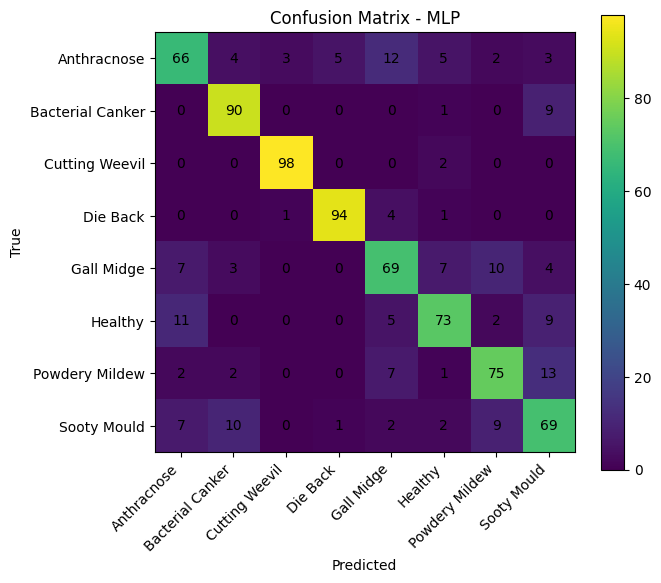

In [105]:
plot_cm(eval_metrics_mlp['confusion_matrix'], "Confusion Matrix - MLP")

Ahora mostramos como se puede guardar el modelo para hacer predicciones futuras 

El reporte de clasificación del conjunto de prueba y la matriz de confusión para el modelo MLP muestra un desempeño sólido y equilibrado entre las distintas clases. El modelo alcanzó una exactitud global del 79 %, lo que coincide con las métricas macro y ponderadas (precisión, recall y F1-score ≈ 0.79), indicando un rendimiento uniforme y sin dominancia clara de alguna clase.

Analizando por categoría, se observa que las clases 2 y 3 presentan un rendimiento sobresaliente (F1 ≈ 0.96 y 0.94), lo que sugiere que el modelo distingue con gran claridad esas variedades o condiciones de mango. En contraste, las clases 0, 4, 5, 6 y 7 muestran valores más modestos de F1 (entre 0.64 y 0.79), evidenciando que el modelo confunde parcialmente estas categorías, probablemente por similitudes visuales.



Ahora visualizamos algunas de las predicciones

In [144]:
def show_examples_test(df, classes_to_show=range(len(class_names)), per_class=5, seed=RANDOM_STATE):
    random.seed(seed)
    samples = []
    for c in classes_to_show:
        sub = df[df['label'] == c]
        sub = sub[sub['exists'] == True]
        if len(sub) == 0:
            continue
        picks = sub.sample(min(per_class, len(sub)), random_state=seed)
        for _, row in picks.iterrows():
            
            samples.append((c, row['image_path'],row['pred']))
    if not samples:
        print("No hay imágenes disponibles para mostrar.")
        return
    n = len(samples)
    cols = per_class
    rows = math.ceil(n / cols)
    plt.figure(figsize=(5*cols, 3*rows))
    for i, (c, p, pred) in enumerate(samples, 1):
        try:
            img = Image.open(p).convert('RGB')
            plt.subplot(rows, cols, i)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"true = {class_names[c-1]}, predicted = {class_names[pred-1]}")
        except Exception as e:
            print(e)
            pass
    plt.tight_layout()
    plt.show()

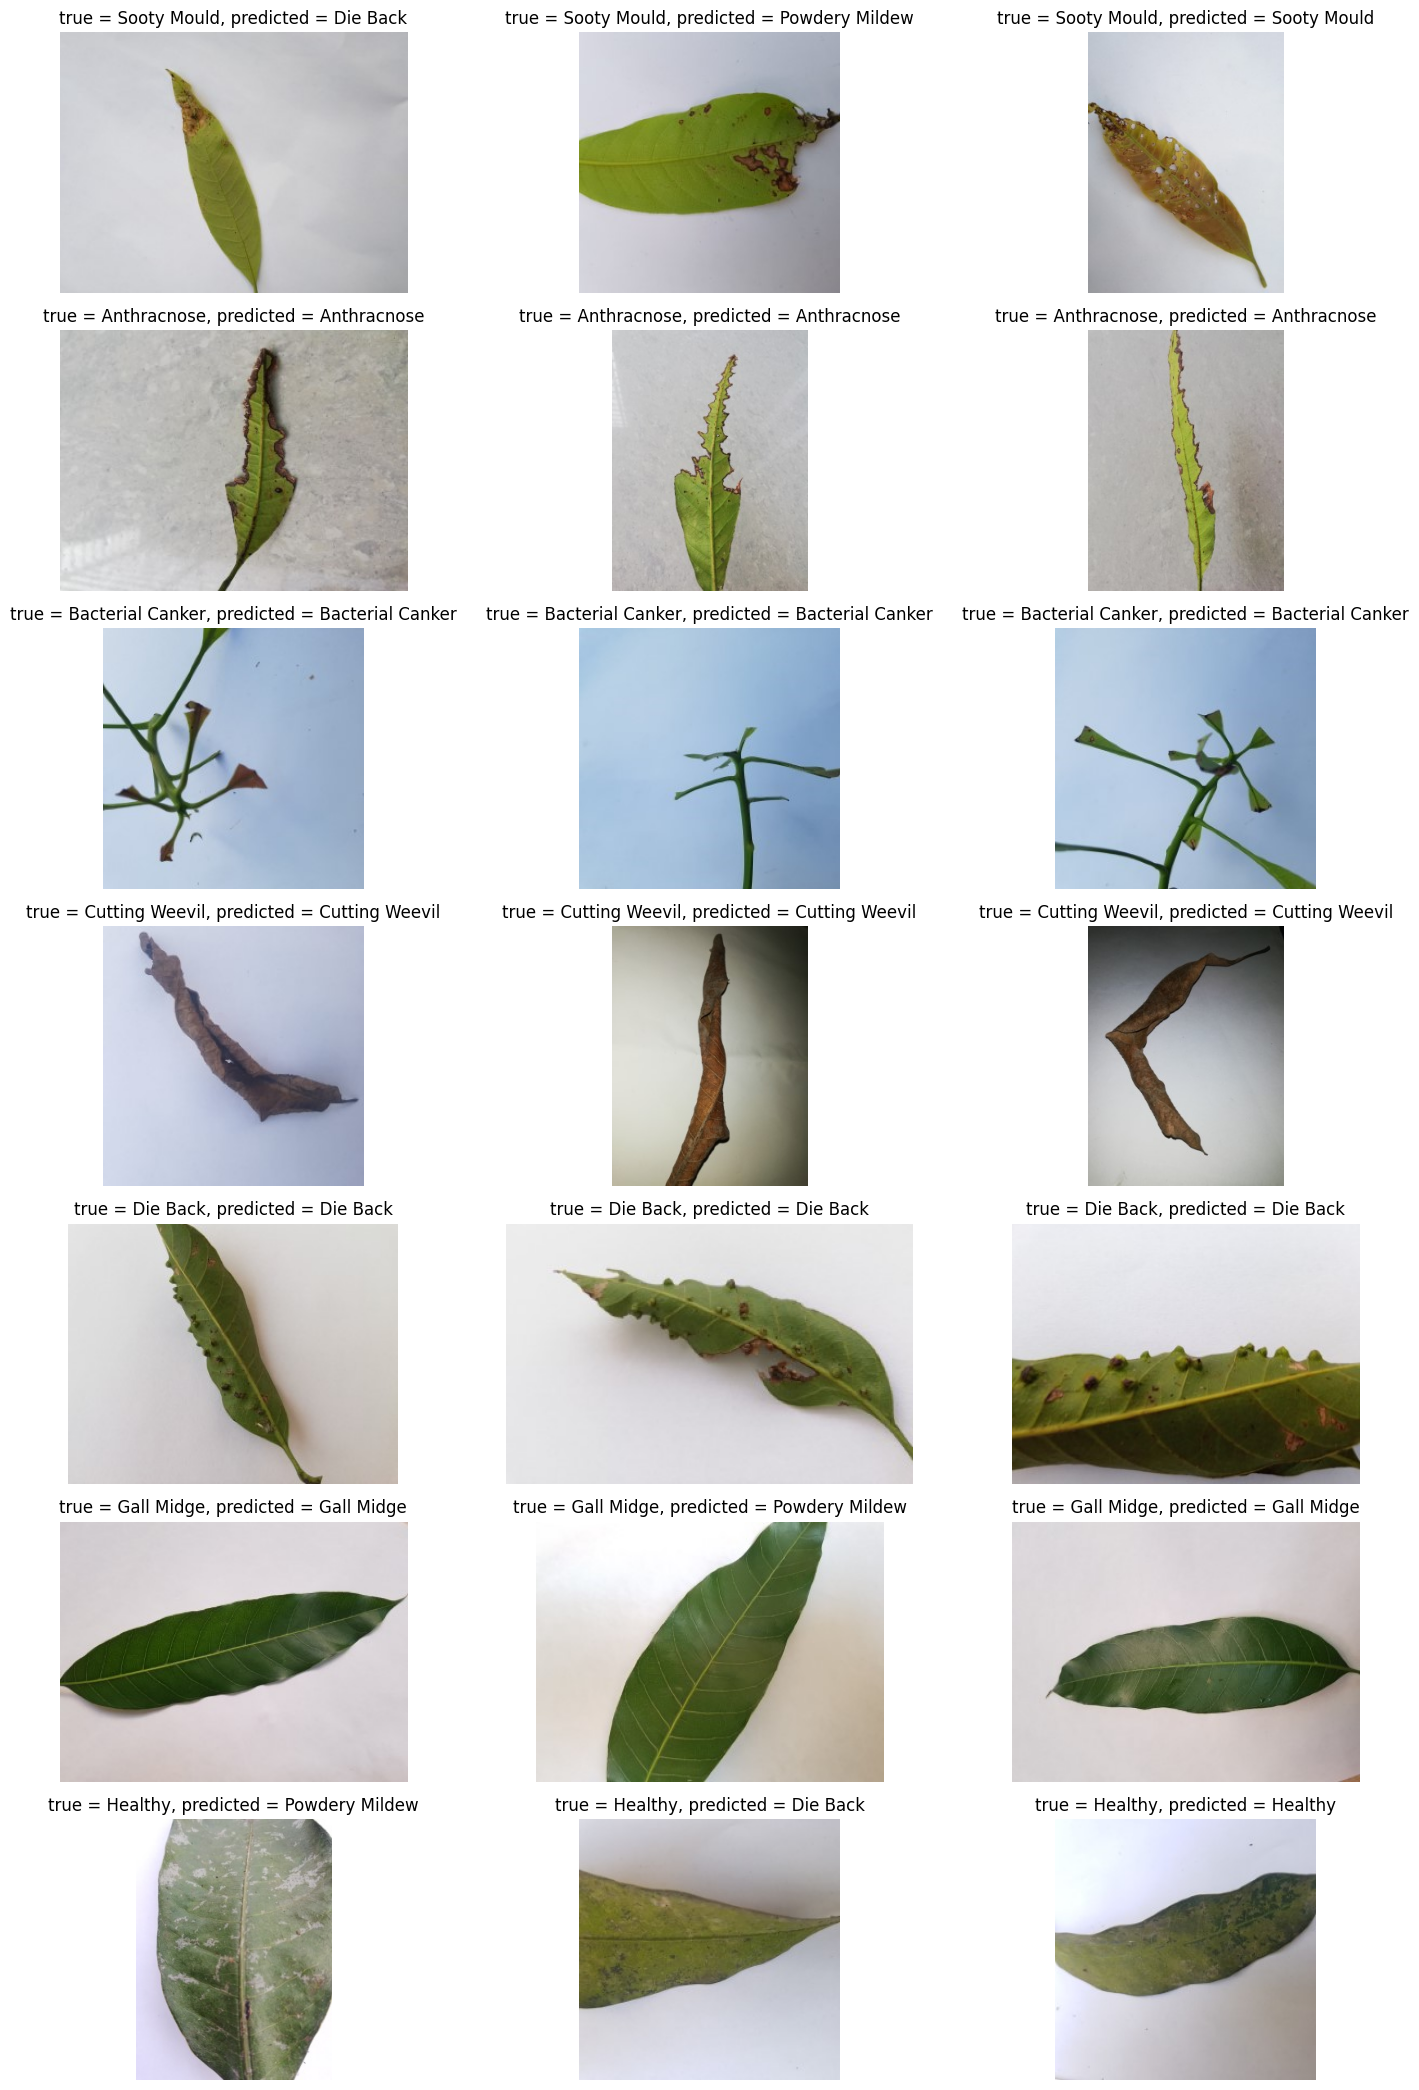

In [146]:
show_examples_test(df_test, classes_to_show=range(0, min(7, len(class_names))), per_class=3)
